### Loading data from the Lakehouse
In this step, we load all relevant AdventureWorks tables directly from the Fabric Lakehouse using Spark.  
Each table is first read as a Spark DataFrame and then converted to pandas for easier data manipulation and analysis later in the notebook.


In [5]:
# Spark DataFrames
sales20_spark = spark.read.table("sales2020")
sales21_spark = spark.read.table("sales2021")
sales22_spark = spark.read.table("sales2022")

returns_spark   = spark.read.table("returns")
customers_spark = spark.read.table("customers")
products_spark  = spark.read.table("product")
territory_spark = spark.read.table("territory")

# Spark to Pandas
sales20   = sales20_spark.toPandas()
sales21   = sales21_spark.toPandas()
sales22   = sales22_spark.toPandas()
returns   = returns_spark.toPandas()
customers = customers_spark.toPandas()
products  = products_spark.toPandas()
territory = territory_spark.toPandas()


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 7, Finished, Available, Finished)

### Building the complete analytical dataset
In this step, we load all relevant tables directly from the Microsoft Fabric Lakehouse and consolidate them into a unified dataset for analysis. 
We begin by reading the sales, product, and customer tables into pandas, ensuring that key fields share consistent data types to avoid merge conflicts. 
Date fields are standardized, and the three yearly sales tables are combined into a single dataset.

After preparing the data, we enrich each sales record by joining product and customer attributes. 
The resulting `sales_full` dataset serves as the foundation for all subsequent exploration, reporting, and correlation analysis.


In [2]:
import pandas as pd

# Load all relevant tables from the Lakehouse as pandas DataFrames
sales20 = spark.read.table("sales2020").toPandas()
sales21 = spark.read.table("sales2021").toPandas()
sales22 = spark.read.table("sales2022").toPandas()

products  = spark.read.table("product").toPandas()
customers = spark.read.table("customers").toPandas()
returns   = spark.read.table("returns").toPandas()
territory = spark.read.table("territory").toPandas()

# Combine the three yearly sales tables
sales = pd.concat([sales20, sales21, sales22], ignore_index=True)

# Ensure key fields use the same data type (nullable integers)
sales["ProductKey"]   = pd.to_numeric(sales["ProductKey"], errors="coerce").astype("Int64")
sales["CustomerKey"]  = pd.to_numeric(sales["CustomerKey"], errors="coerce").astype("Int64")
products["ProductKey"]  = pd.to_numeric(products["ProductKey"], errors="coerce").astype("Int64")
customers["CustomerKey"] = pd.to_numeric(customers["CustomerKey"], errors="coerce").astype("Int64")

# Standardize date fields
sales["OrderDate"] = pd.to_datetime(sales["OrderDate"], errors="coerce")
sales["StockDate"] = pd.to_datetime(sales["StockDate"], errors="coerce") if "StockDate" in sales.columns else None

# Remove duplicate records across tables
sales     = sales.drop_duplicates()
products  = products.drop_duplicates()
customers = customers.drop_duplicates()
returns   = returns.drop_duplicates()

# Basic handling of missing values
sales["OrderQuantity"]   = pd.to_numeric(sales["OrderQuantity"], errors="coerce").fillna(0)
returns["ReturnQuantity"] = pd.to_numeric(returns["ReturnQuantity"], errors="coerce").fillna(0)

# Build the final unified dataset by merging sales with product and customer details
sales_full = sales.merge(products, on="ProductKey", how="left")
sales_full = sales_full.merge(customers, on="CustomerKey", how="left")

sales_full.head()


StatementMeta(, 1e558c07-8149-4110-881f-f1f7c0246e5b, 4, Finished, Available, Finished)

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,...,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner
0,2020-08-02,2020-06-18,SO47082,322,15254,5,1,1,2,BK-R50R-60,...,CHAPMAN,1980-02-24,M,F,carla5@adventure-works.com,40000.0,0.0,High School,Skilled Manual,N
1,2020-01-01,2019-11-16,SO45081,338,26782,6,1,1,2,BK-R50B-44,...,LEWIS,1980-09-25,S,M,seth20@adventure-works.com,30000.0,0.0,High School,Skilled Manual,N
2,2020-01-03,2019-09-11,SO45094,310,22785,6,1,1,2,BK-R93R-62,...,PERRY,1952-01-13,M,M,oscar16@adventure-works.com,70000.0,2.0,Partial High School,Skilled Manual,Y
3,2020-01-05,2019-09-19,SO45101,313,22748,6,1,1,2,BK-R93R-52,...,PHILLIPS,1946-09-13,S,M,adam36@adventure-works.com,70000.0,5.0,Bachelors,Management,Y
4,2020-01-06,2019-10-01,SO45108,310,22975,6,1,1,2,BK-R93R-62,...,TURNER,1978-09-12,S,F,courtney2@adventure-works.com,30000.0,0.0,Partial High School,Clerical,N


### Refining and validating the enriched dataset
After merging the sales, product, and customer information, we perform an additional cleaning step to ensure the quality of the unified dataset.  
Duplicate records are removed, key numeric fields are standardized, and missing or invalid values are handled.  
We also enforce simple business rules—such as excluding rows with missing dates or negative quantities—to ensure that the final dataset is reliable for downstream analysis and visualizations.


In [16]:
# Remove duplicate rows
sales_full = sales_full.drop_duplicates()

# Fix date and numeric columns
sales_full["OrderDate"] = pd.to_datetime(sales_full["OrderDate"], errors="coerce")
sales_full["OrderQuantity"] = pd.to_numeric(sales_full["OrderQuantity"], errors="coerce")

# Convert product price and cost if they exist
if "ProductPrice" in sales_full.columns:
    sales_full["ProductPrice"] = pd.to_numeric(sales_full["ProductPrice"], errors="coerce")

if "ProductCost" in sales_full.columns:
    sales_full["ProductCost"] = pd.to_numeric(sales_full["ProductCost"], errors="coerce")

# Remove rows without essential values (simple cleaning)
sales_full = sales_full.dropna(subset=["OrderDate", "OrderQuantity"])

# Remove negative quantities (basic sanity rule)
sales_full = sales_full[sales_full["OrderQuantity"] >= 0]

sales_full.head()


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 18, Finished, Available, Finished)

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,...,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner
0,2020-08-02,2020-06-18,SO47082,322,15254,5,1,1,2,BK-R50R-60,...,CHAPMAN,1980-02-24,M,F,carla5@adventure-works.com,40000.0,0.0,High School,Skilled Manual,N
1,2020-01-01,2019-11-16,SO45081,338,26782,6,1,1,2,BK-R50B-44,...,LEWIS,1980-09-25,S,M,seth20@adventure-works.com,30000.0,0.0,High School,Skilled Manual,N
2,2020-01-03,2019-09-11,SO45094,310,22785,6,1,1,2,BK-R93R-62,...,PERRY,1952-01-13,M,M,oscar16@adventure-works.com,70000.0,2.0,Partial High School,Skilled Manual,Y
3,2020-01-05,2019-09-19,SO45101,313,22748,6,1,1,2,BK-R93R-52,...,PHILLIPS,1946-09-13,S,M,adam36@adventure-works.com,70000.0,5.0,Bachelors,Management,Y
4,2020-01-06,2019-10-01,SO45108,310,22975,6,1,1,2,BK-R93R-62,...,TURNER,1978-09-12,S,F,courtney2@adventure-works.com,30000.0,0.0,Partial High School,Clerical,N


### Creating a core business metric: SalesAmount
To support further analysis, we compute a key metric: *SalesAmount*.  
If product prices are available, SalesAmount is calculated as the product of the ordered quantity and the product price.  
This metric will be used throughout the analysis, including yearly trends, product comparisons, and correlation studies.


In [19]:
# Create SalesAmount if ProductPrice exists
if "ProductPrice" in sales_full.columns:
    sales_full["SalesAmount"] = sales_full["OrderQuantity"] * sales_full["ProductPrice"]
else:
    print("No ProductPrice column found")

sales_full.head()


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 21, Finished, Available, Finished)

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,...,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner,SalesAmount
0,2020-08-02,2020-06-18,SO47082,322,15254,5,1,1,2,BK-R50R-60,...,1980-02-24,M,F,carla5@adventure-works.com,40000.0,0.0,High School,Skilled Manual,N,699.0982
1,2020-01-01,2019-11-16,SO45081,338,26782,6,1,1,2,BK-R50B-44,...,1980-09-25,S,M,seth20@adventure-works.com,30000.0,0.0,High School,Skilled Manual,N,699.0982
2,2020-01-03,2019-09-11,SO45094,310,22785,6,1,1,2,BK-R93R-62,...,1952-01-13,M,M,oscar16@adventure-works.com,70000.0,2.0,Partial High School,Skilled Manual,Y,3578.2700
3,2020-01-05,2019-09-19,SO45101,313,22748,6,1,1,2,BK-R93R-52,...,1946-09-13,S,M,adam36@adventure-works.com,70000.0,5.0,Bachelors,Management,Y,3578.2700
4,2020-01-06,2019-10-01,SO45108,310,22975,6,1,1,2,BK-R93R-62,...,1978-09-12,S,F,courtney2@adventure-works.com,30000.0,0.0,Partial High School,Clerical,N,3578.2700


### Calculating yearly sales performance
To understand overall sales trends, we extract the year from each transaction date and aggregate the total SalesAmount per year.  
This provides a high-level view of how revenue evolves over time and forms the basis for later comparisons such as year-over-year growth.


In [20]:
# Sales pr. Year
# Extract year from OrderDate
sales_full["Year"] = sales_full["OrderDate"].dt.year

# Calculate total sales per year
sales_per_year = (
    sales_full
    .groupby("Year")["SalesAmount"]
    .sum()
    .reset_index()
)

sales_per_year


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 22, Finished, Available, Finished)

,Year,SalesAmount
0,2020,6.404934e+06
1,2021,9.324204e+06
2,2022,9.185449e+06


### Identifying the top 5 best-selling products
To highlight which products drive the most revenue, we group sales by product name and rank them by total SalesAmount.  
This simple aggregation identifies the top five performers, providing quick business insights into which products contribute most to overall sales.


In [23]:
#top 5 products and sales amount
top5_products = (
    sales_full
    .groupby("ProductName")["SalesAmount"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

top5_products


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 25, Finished, Available, Finished)

,ProductName,SalesAmount
0,"Mountain-200 Black, 46",1.241754e+06
1,"Mountain-200 Black, 42",1.233557e+06
2,"Mountain-200 Silver, 38",1.213852e+06
3,"Mountain-200 Silver, 46",1.182781e+06
4,"Mountain-200 Black, 38",1.165937e+06


### Correlation analysis using a heatmap
To explore relationships between the numerical variables in the dataset, we compute a correlation matrix and visualize it using a heatmap.  
This helps identify which factors move together—for example, SalesAmount typically correlates strongly with quantity and price—while also revealing variables that show little or no statistical relationship.


StatementMeta(, a88d4dcd-3515-4d39-b859-6217528633f4, 26, Finished, Available, Finished)

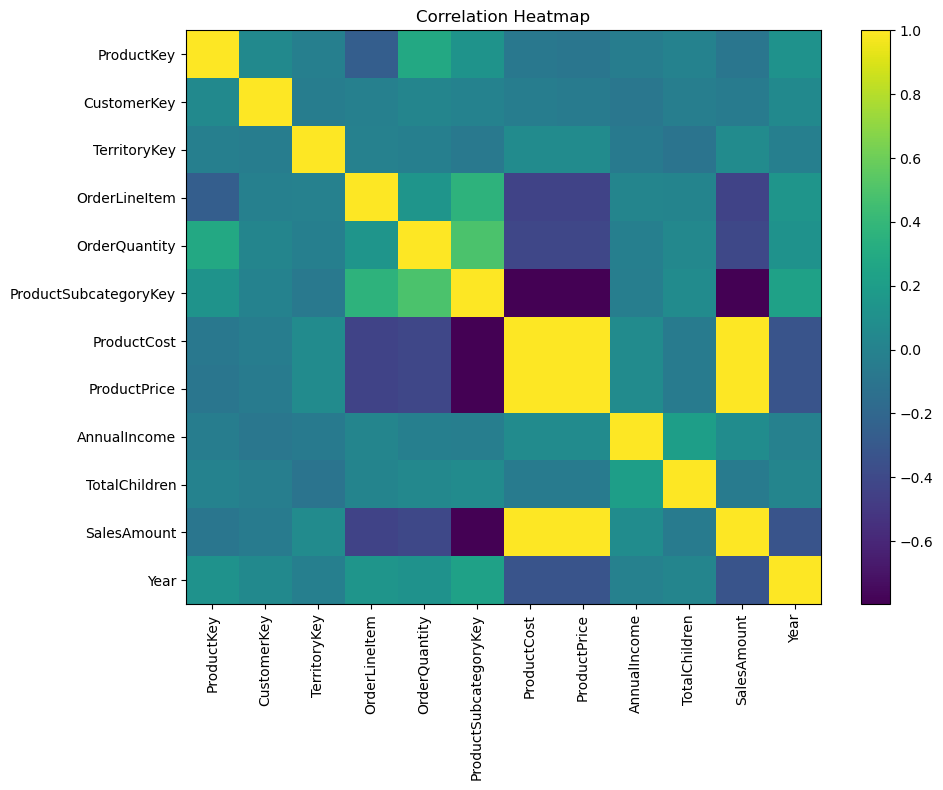

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_df = sales_full.select_dtypes(include=[np.number]).copy()

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap (no explicit colors, uses matplotlib default)
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation Heatmap")
plt.tight_layout()


The correlation heatmap shows how strongly the numerical variables in the dataset are related to each other. Values close to 1 indicate a strong positive relationship, values close to –1 indicate a strong negative relationship, and values around 0 show no meaningful correlation.

In this dataset, SalesAmount correlates strongly with ProductPrice and OrderQuantity, which is expected because SalesAmount is calculated from these fields. Customer demographics and product IDs show very weak correlations, meaning they do not directly influence sales in this dataset.

Overall, the heatmap helps identify the variables that actually drive sales performance, and here the main drivers are simply price and quantity.